In [62]:
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

## Creating Depth and Color Images

In [63]:
width = 1280
height = 720
fps = 30

In [64]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, fps)

In [84]:
profile = pipeline.start(config)

In [85]:
align_to = rs.stream.color
align = rs.align(align_to)

In [86]:
frames = pipeline.wait_for_frames()

In [87]:
aligned_frames = align.process(frames)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

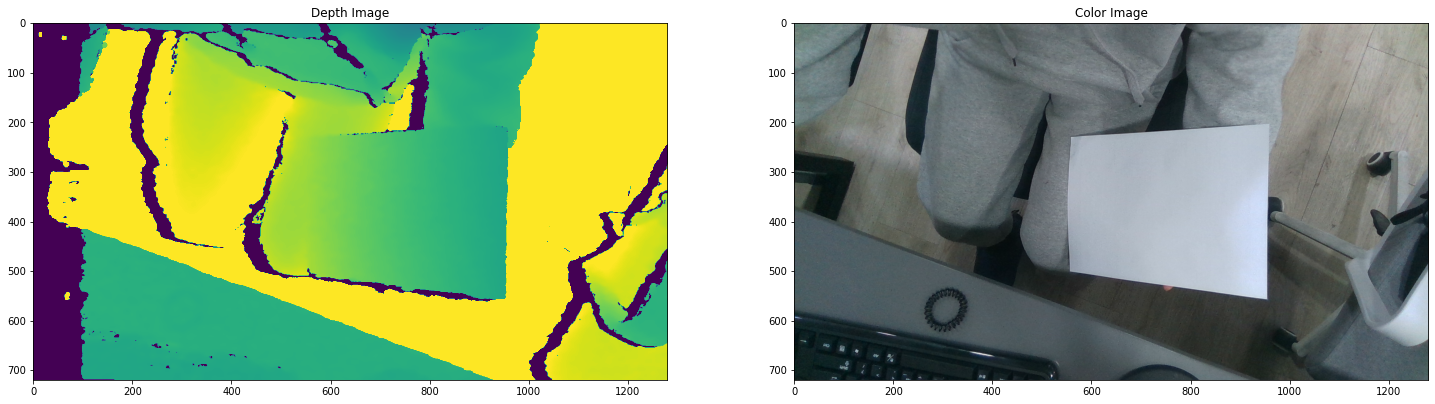

In [88]:
fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(color_image)
ax2.set_title("Color Image")

plt.show()

In [89]:
pipeline.stop()

## Filtering a Depth Image

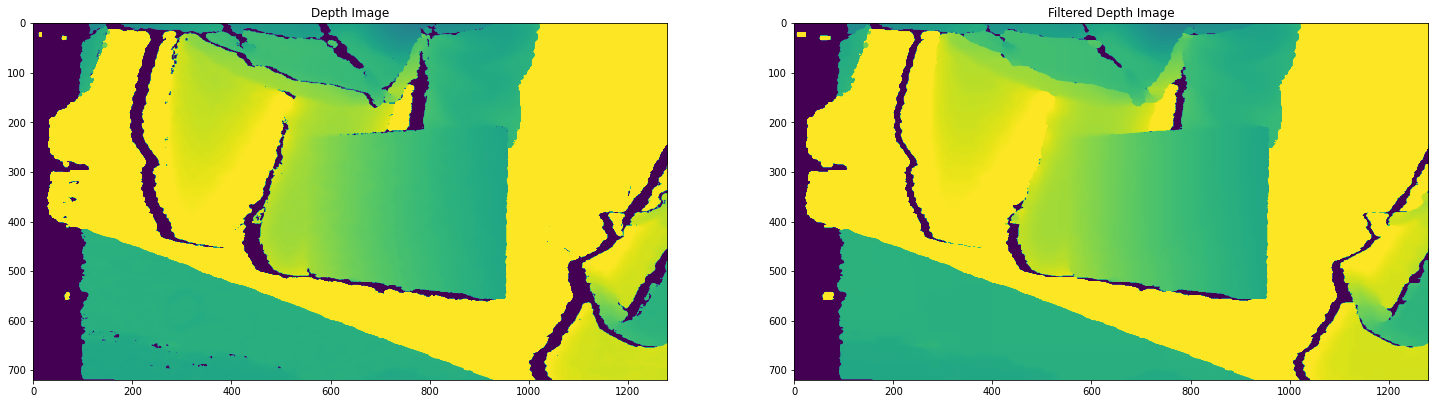

In [90]:
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 2)

filtered_depth = spatial.process(depth_frame)
filtered_depth_image = np.asanyarray(filtered_depth.get_data())

fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(filtered_depth_image, vmin=200, vmax=800)
ax2.set_title("Filtered Depth Image")

plt.show()

## Image Save

In [91]:
np.save('depth_image.npy', depth_image)
np.save('filtered_depth_image.npy', filtered_depth_image)
np.save('color_image.npy', color_image)

## Mask and Normal Vector Generation

In [92]:
def generate_mask(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,255,0),5,16)
        cv2.imshow("Mask",data["im"])
        if len(data["points"]) < 4:
            data['points'].append([x,y])

def get_normal(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,0,255),5,16)
        cv2.imshow("Normal",data["im"])
        if len(data["points"]) < 3:
            data['points'].append([x,y])
    
def get_points(im,type):
    data = {}
    data['im'] = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2BGR)
    data['points'] = []
    
    if type == "mask":
        cv2.imshow("Mask",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Mask",generate_mask,data)
    else:
        cv2.imshow("Normal",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Normal",get_normal,data)
    cv2.waitKey(0)

    points = np.array(data['points'],dtype=float)
    return points


In [93]:
depth_image = np.load('filtered_depth_image.npy')
color_image = np.load('color_image.npy')

In [94]:
mask_points = get_points(color_image,"mask")

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to tar

In [95]:
np.save('mask_points.npy', mask_points)
mask_points

array([[557., 231.],
       [556., 501.],
       [955., 557.],
       [958., 204.]])

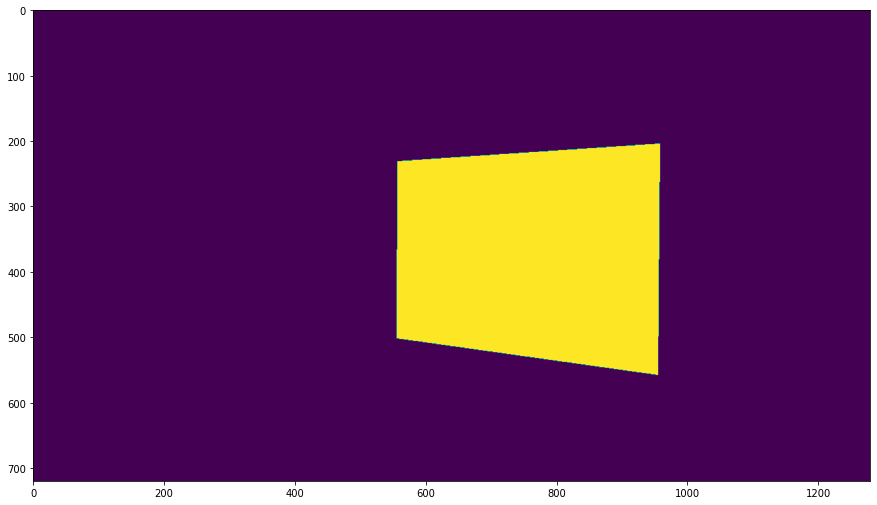

In [96]:
mask_points = np.load('mask_points.npy')
mask = np.zeros(color_image.shape[:2], dtype="uint8")

cv2.fillPoly(mask, np.int32([mask_points]), 1)
plt.figure(figsize=(15,25))
plt.imshow(mask)

In [97]:
def seed_everything(num: int = 42):
    random.seed(num)
    np.random.seed(num)
    os.environ["PYTHONHASHSEED"] = str(num)

seed_everything()

non_index = np.nonzero(mask)
num = len(non_index[0])

normal_x = []
normal_y = []
for _ in range(100):
    random_ = np.random.choice(num, size=3, replace=False)
    normal_y.append(non_index[0][random_])
    normal_x.append(non_index[1][random_])

normal_y = np.array(normal_y)
normal_x = np.array(normal_x)

normal_points = np.transpose(np.array((normal_x[0], normal_y[0])))

In [98]:
masked_depth = cv2.bitwise_and(depth_image,depth_image,mask=mask)

import math

deg_h = 69.4
deg_v = 42.5

px_h = masked_depth * math.tan(math.radians(deg_h/2)) / (depth_image.shape[1] / 2)
px_v = masked_depth * math.tan(math.radians(deg_v/2)) / (depth_image.shape[0] / 2)

x_center = 0
y_center = 0
for i in range(3):
    x_center += normal_points[i][0] / 3
    y_center += normal_points[i][1] / 3

x_center = math.ceil(x_center)
y_center = math.ceil(y_center)

sum_x = 0
x_coor = []
for i in range(3):
    coor = np.int64(normal_points[i])
    if x_center <= coor[0]:
        sum_x = np.sum(px_h[y_center, x_center:coor[0]+1])
    else:
        sum_x = np.sum(px_h[y_center, coor[0]:x_center+1])
        sum_x = -sum_x
    x_coor.append(sum_x)
    sum_x = 0

sum_y = 0
y_coor = []
for i in range(3):
    coor = np.int64(normal_points[i])
    if y_center <= coor[1]:
        sum_y = np.sum(px_v[y_center:coor[1]+1,x_center])
        sum_y = -sum_y
    else:
        sum_y = np.sum(px_v[coor[1]:y_center+1,x_center])
    y_coor.append(sum_y)
    sum_y = 0

x_coor, y_coor

([60.11290681513048, 10.134403594919586, -73.39896170416779],
 [-32.40872142514832, -19.690226456156374, 51.350356322487706])

In [99]:
if width/2 <= x_center:
    x_true = np.array(x_coor) + width/2
else:
    x_true = np.array(x_coor) - width/2

if height/2 <= y_center:
    y_true = np.array(y_coor) + height/2
else:
    y_true = np.array(y_coor) - height/2  

x_true, y_true

(array([700.11290682, 650.13440359, 566.6010383 ]),
 array([-392.40872143, -379.69022646, -308.64964368]))

In [100]:
A_xy = np.array([x_coor[0],y_coor[0]])
B_xy = np.array([x_coor[1],y_coor[1]])
C_xy = np.array([x_coor[2],y_coor[2]])

normal_points = np.int64(normal_points)

A = np.append(A_xy,depth_image[normal_points[0][1]][normal_points[0][0]])
B = np.append(B_xy,depth_image[normal_points[1][1]][normal_points[1][0]])
C = np.append(C_xy,depth_image[normal_points[2][1]][normal_points[2][0]])

AB = B - A
CB = B - C
normal = np.cross(AB,CB)
norm_unit = normal / np.linalg.norm(normal)

norm_unit

array([ 0.41711163, -0.07074224,  0.90609791])

In [101]:
camera = np.array([0,-1])

norm_unit_x = np.array([norm_unit[0], norm_unit[2]])
norm_unit_x = norm_unit_x / np.linalg.norm(norm_unit_x)

norm_unit_y = np.array([norm_unit[1], norm_unit[2]])
norm_unit_y = norm_unit_y / np.linalg.norm(norm_unit_y)

dot_product_x = np.dot(camera, norm_unit_x)
dot_product_y = np.dot(camera, norm_unit_y)
angle_x = np.arccos(dot_product_x)
angle_y = np.arccos(dot_product_y)

np.degrees(angle_x), np.degrees(angle_y)

(155.2815706585748, 175.5357737298381)

In [102]:
px_h_true = px_h / math.cos(angle_x)
px_v_true = px_v / math.cos(angle_y)

area = px_h_true * px_v_true
paper_area = np.sum(area)

error = np.abs(paper_area - 62370)/62370 * 100

print("Area of the paper is {:0.2f} mm^2.".format(paper_area))
print("True value is 62370 mm^2.")
print("Percent error is {:0.2f}%.".format(error))

Area of the paper is 63825.85 mm^2.
True value is 62370 mm^2.
Percent error is 2.33%.
